<div style="color:#5dade2 ;
           display:fill;
           border-radius:5px;
           font-family:Verdana;
           letter-spacing:0.5px;
           background-color:black;
           text-align:center;
           padding: 10px;">

<h1 id="head2">
    <p style="padding: 6px;
              font-size:100%;
              color:#5dade2 ;
              text-align:center;">
              Reinforced Learning
    </p>
</h1>
<h3> 
    Juan Merchán
</h3>
</div>

# Introduction

<H4>
In this mini-project, two approaches are compared for controlling the Pendulum-v1 environment: a random policy versus a policy learned using the <strong>Soft Actor-Critic (SAC)</strong> algorithm, a modern method in deep reinforcement learning.
</H4>
<H4>
The goal is to analyze the evolution of rewards over multiple episodes, evaluating the performance, stability, and efficiency of each strategy. To achieve this, a SAC agent is trained for a limited number of steps, and episode rewards are recorded to build a visual and quantitative comparison.
</H4>
<H4>
This exercise clearly demonstrates how a trained agent can significantly outperform a non-learning policy, even in a continuous control environment like the inverted pendulum.
</H4>

# Libraries

In [1]:
# Numbers
import numpy as np
import pandas as pd
from time import time

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Gymnasium
import gymnasium as gym

# Random Model

<H4>
The random model consists of an agent that interacts with the environment by selecting actions completely at random, without following any learned policy or optimization logic.
</H4>
<H4>
In the Pendulum-v1 environment, this means the agent applies torques without considering the pendulum’s state, resulting in inefficient movements and generally low rewards.
</H4>
<H4>
This model serves as a baseline for evaluating the performance of reinforcement learning methods. Comparing it to a trained agent allows us to measure how much the behavior improves when learning techniques are applied.
</H4>

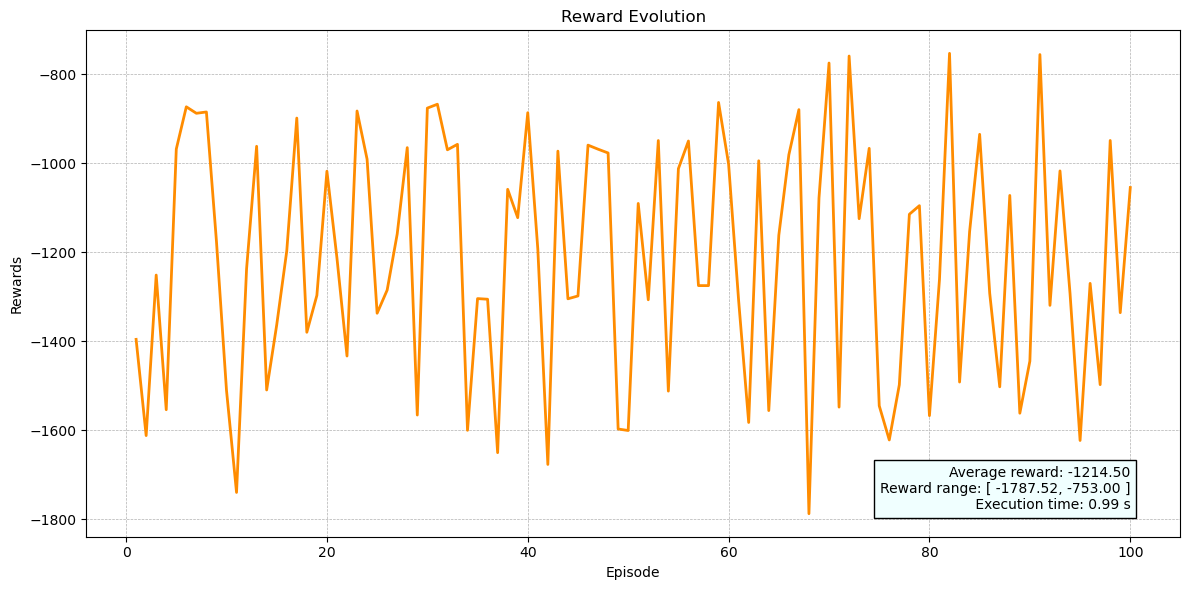

In [2]:
# Basic Model
env = gym.make("Pendulum-v1")
obs, _ = env.reset(seed=42)

total_reward = 0
baseline_rewards = []

EPISODES = 100
STEPS_PER_EPISODE = 200  # default for Pendulum-v1

start_baseline = time()
for episode in range(EPISODES):
    obs, _ = env.reset()
    ep_reward = 0
    for _ in range(STEPS_PER_EPISODE):
        action = env.action_space.sample()  # random torque in [-2, 2]
        obs, reward, terminated, truncated, _ = env.step(action)
        ep_reward += reward
        if terminated or truncated:
            break
    baseline_rewards.append(ep_reward)

end_baseline = time()

env.close()

# Performance Plot

baselines_results = pd.DataFrame({
    'Episode': [i for i in range(1, len(baseline_rewards) + 1)],
    'Rewards': baseline_rewards
})

plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data = baselines_results,
    x = 'Episode',
    y = 'Rewards',
    color = 'darkorange',
    linewidth=2
)

ax.text(EPISODES, np.min(baseline_rewards) + 10, f"Average reward: {np.mean(baseline_rewards):.2f}\nReward range: [ {np.min(baseline_rewards):.2f}, {np.max(baseline_rewards):.2f} ]\n Execution time: {(end_baseline - start_baseline):.2f} s", 
        bbox=dict(facecolor='azure', edgecolor='black'), horizontalalignment='right')

plt.title('Reward Evolution')
plt.grid(
    linewidth=0.5, 
    linestyle='--'
)
plt.tight_layout()
plt.show()


# Model with SAC
<H4>
In this experiment, a reinforcement learning agent is implemented using the Soft Actor-Critic (SAC) algorithm. This agent is trained to learn how to control the Pendulum-v1 environment, whose objective is to keep a pendulum upright by applying continuous torques.
</H4>

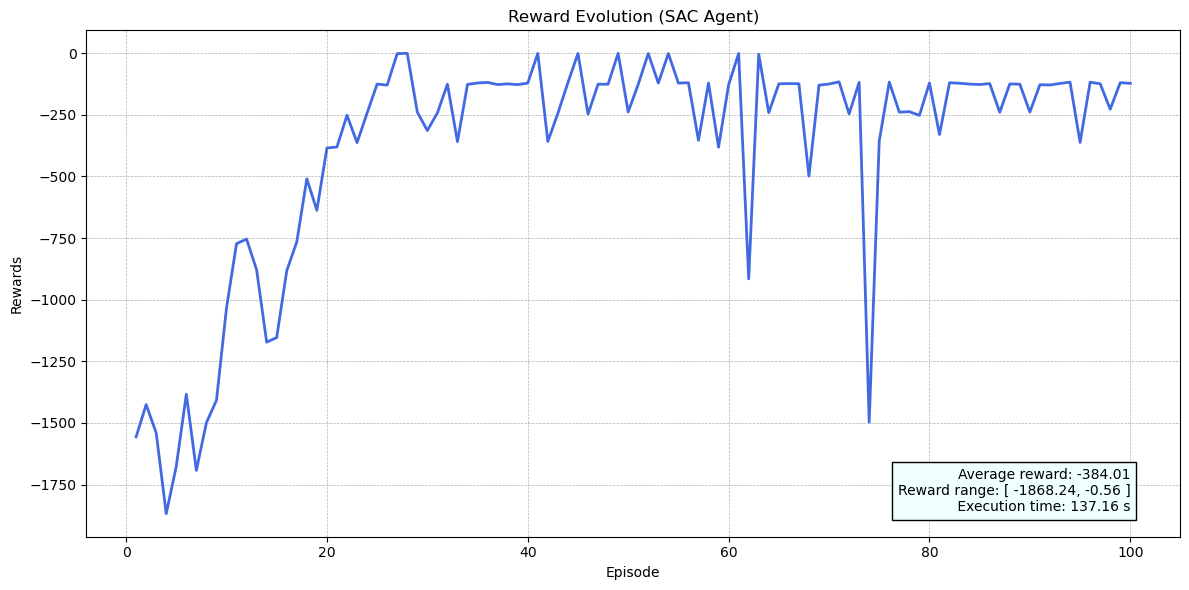

In [3]:
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

# Important class for tracking episode rewards
class RewardCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals["rewards"][0]
        done = self.locals["dones"][0]
        if done:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

# Create environment
env = gym.make("Pendulum-v1")
env = Monitor(env)  # to record rewards

# Initialize SAC model
model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=0,
    learning_rate=3e-4,
    buffer_size=5000,
    batch_size=64,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1
)

# Train model
start_ann = time()

reward_callback = RewardCallback()
model.learn(total_timesteps=20000, callback=reward_callback)
ann_rewards = reward_callback.episode_rewards

end_ann = time()

ann_results = pd.DataFrame({
    'Episode': [i for i in range(1, len(ann_rewards) + 1)],
    'Rewards': ann_rewards
})

plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data = ann_results,
    x = 'Episode',
    y = 'Rewards',
    color = 'royalblue',
    linewidth=2
)

ax.text(100, np.min(ann_results) + 10, f"Average reward: {np.mean(ann_rewards):.2f}\nReward range: [ {np.min(ann_rewards):.2f}, {np.max(ann_rewards):.2f} ]\n Execution time: {(end_ann - start_ann):.2f} s", 
        bbox=dict(facecolor='azure', edgecolor='black'), horizontalalignment='right')

plt.title('Reward Evolution (SAC Agent)')
plt.grid(
    linewidth=0.5, 
    linestyle='--'
)
plt.tight_layout()
plt.show()


# Comparison (Episode 20+)

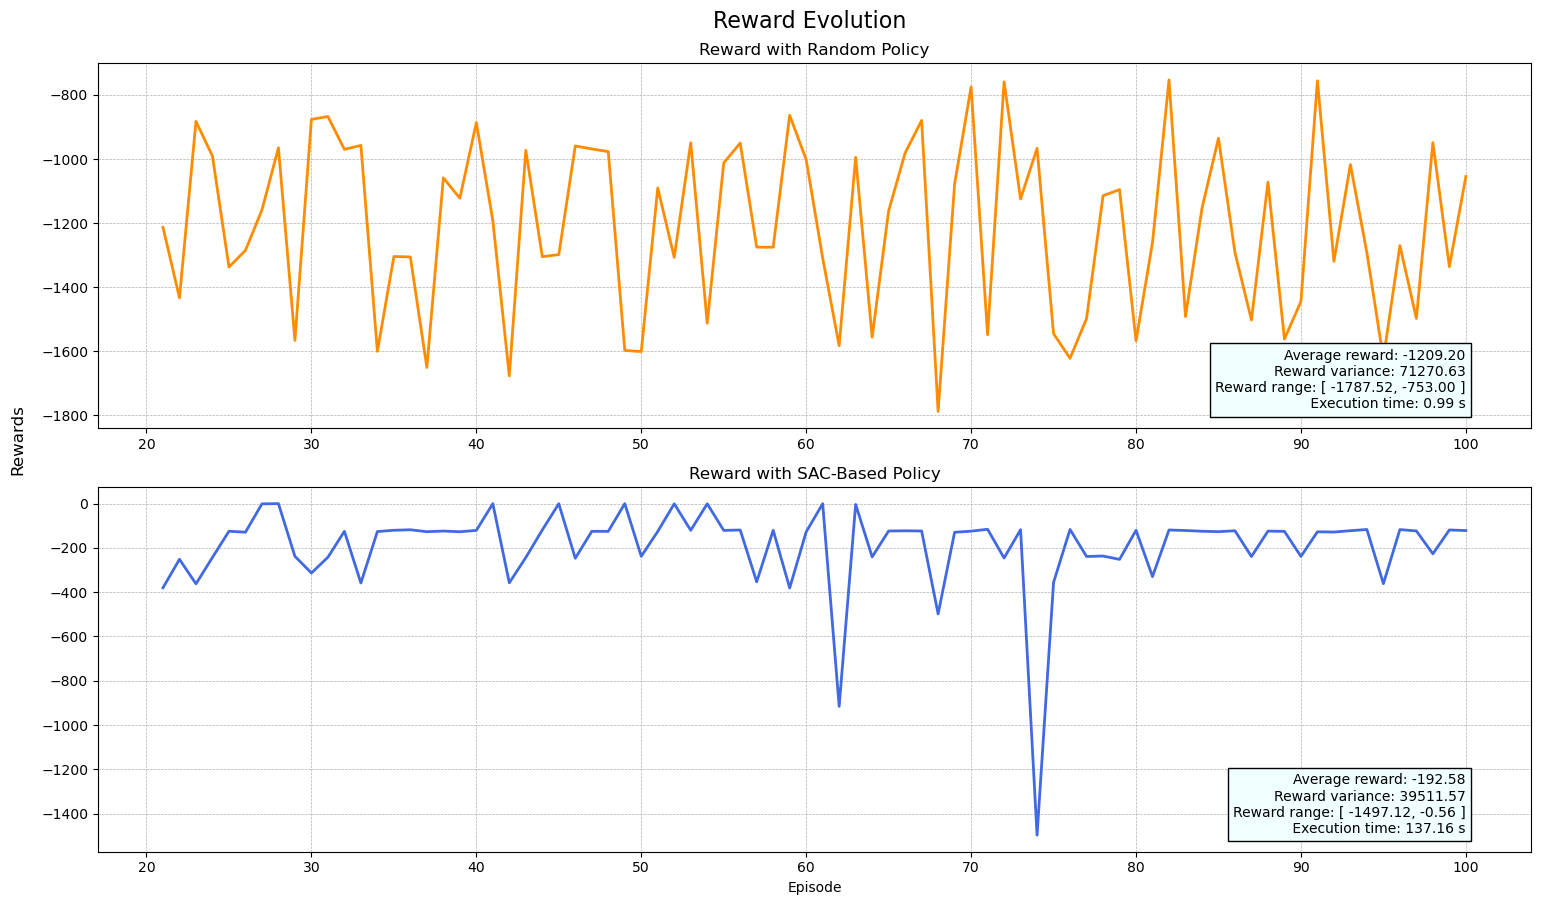

In [5]:
# Combined Graphs (Episode 20+)

baseline_rewards_20 = baseline_rewards[20:]
baselines_results_20 = baselines_results.iloc[20:,:]
ann_rewards_20 = ann_rewards[20:]
ann_results_20 = ann_results.iloc[20:,:]

fig, axs = plt.subplots(2,1, figsize=(16, 10))

# Random Policy
ax = sns.lineplot(
    data = baselines_results_20,
    x = 'Episode',
    y = 'Rewards',
    color = 'darkorange',
    linewidth=2,
    ax=axs[0]
)

ax.text(EPISODES, np.min(baseline_rewards_20) + 10, f"Average reward: {np.mean(baseline_rewards_20):.2f}\nReward variance: {np.var(baseline_rewards_20):.2f}\nReward range: [ {np.min(baseline_rewards_20):.2f}, {np.max(baseline_rewards_20):.2f} ]\n Execution time: {(end_baseline - start_baseline):.2f} s", 
        bbox=dict(facecolor='azure', edgecolor='black'), horizontalalignment='right')

axs[0].set_title('Reward with Random Policy')
axs[0].grid(
    linewidth=0.5, 
    linestyle='--'
)
axs[0].set_xlabel('')
axs[0].set_ylabel('')

# SAC Policy
ax = sns.lineplot(
    data = ann_results_20,
    x = 'Episode',
    y = 'Rewards',
    color = 'royalblue',
    linewidth=2,
    ax=axs[1]
)

ax.text(100, np.min(ann_results_20) + 10, f"Average reward: {np.mean(ann_rewards_20):.2f}\nReward variance: {np.var(ann_rewards_20):.2f}\nReward range: [ {np.min(ann_rewards_20):.2f}, {np.max(ann_rewards_20):.2f} ]\n Execution time: {(end_ann - start_ann):.2f} s", 
        bbox=dict(facecolor='azure', edgecolor='black'), horizontalalignment='right')

axs[1].set_title('Reward with SAC-Based Policy')
axs[1].grid(
    linewidth=0.5, 
    linestyle='--'
)
axs[1].set_ylabel('')

fig.suptitle('Reward Evolution', fontsize=16, x=0.54, y=0.93)
fig.text(0.04, 0.5, 'Rewards', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.show()

<H4>
It can be observed that using the SAC strategy results in significantly higher and more stable rewards compared to the random policy.  
While the random policy shows high variability and consistently low rewards (average ≈ -1209), the agent trained with SAC considerably increases the average reward value (≈ -192) and keeps it within a more favorable range.  
Additionally, the reward variance in the SAC model is much lower, indicating more predictable and reliable behavior.  
This demonstrates that the agent has learned an effective policy to solve the Pendulum-v1 environment task, clearly outperforming the random behavior.
</H4>

**Thank you**

Code by: Juan Merchán.